In [29]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import os
import sys
sys.path.append('/home/vaschetti/maxarSrc/datasets_and_samplers')
from myGeoDatasets import Maxar
from mySamplers import MyGridGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
from samplers_utils import boundingBox_2_Polygon
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2
import supervision as sv
import torch




Initialize SAM

In [30]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/vaschetti/maxarSrc/creating_labels/models/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device='cuda:1')

predictor = SamPredictor(sam)

Creazione del dataset delle immagini

In [31]:
dataset = Maxar('/mnt/data2/vaschetti_data/maxar/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031213.tif')
sampler = MyGridGeoSampler(dataset, size=600, stride=600)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)
data_crs = dataset.crs

Creazione dataset degli edifici

In [32]:
from build_seg_utils import building_gdf
gdfs_32628 = building_gdf('TheGambia', dataset_crs = data_crs)
index_MS_buildings = gdfs_32628.sindex

Found 6 links for TheGambia


Iterate over the dataloader

In sampler
tile_polygon:  POLYGON ((320156.25 1489843.75, 315455.322265625 1489843.75, 315470.63516642543 1492342.8892077415, 320156.25 1491748.5059546148, 320156.25 1489843.75))
In plot
Crs EPSG:32628
sx_low:  (317773.4375, 1489843.75)
dx_high:  (317956.54296875, 1490026.85546875)


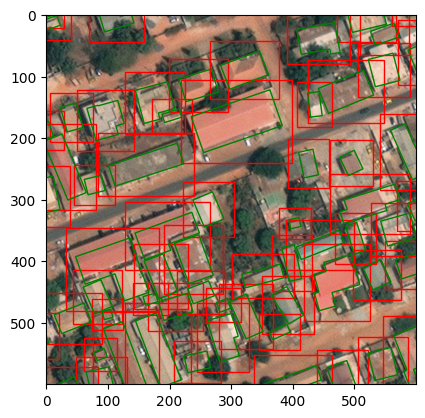

In [33]:
from random import randint
from build_seg_utils import rel_bbox_coords, rel_polyg_coord
dataset_res = dataset.res
i = 0
for batch in dataloader:
    query_bbox_poly = boundingBox_2_Polygon(batch['bbox'][0])
    hits = index_MS_buildings.query(query_bbox_poly)
    if len(hits) > 30: #per prendere immagini con almeno X edifici
        i+=1
        if i == randint(0, 20): #per prendere immagini random
            sample = unbind_samples(batch)[0]
            img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')
            
            predictor.set_image(img4Sam) #encoding the image

            #Getting the relative coordinates of the buildings boxes
            building_boxes = rel_bbox_coords(gdfs_32628.iloc[hits], query_bbox_poly.bounds, dataset_res, ext_mt=10)

            #Plotting
            fig, ax = dataset.plot(sample)   
            for box in building_boxes:
                x0, y0 = box[0], box[1]
                w, h = box[2] - box[0], box[3] - box[1]
                rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')            
                ax.add_patch(rect)
            for rel_pol in rel_polyg_coord(gdfs_32628.iloc[hits], query_bbox_poly.bounds, dataset_res):
                poly = patches.Polygon(rel_pol, linewidth=1, edgecolor='g', facecolor='none')
                ax.add_patch(poly)

            break


Prepare data for the model

In [34]:
import torch
#prepare the data for the model
building_boxes_t = torch.tensor(building_boxes, device=predictor.device)

#Given the box coorindates as xyxy return the center of the rectangle
point_coords = torch.tensor([[(sublist[0] + sublist[2])/2, (sublist[1] + sublist[3])/2] for sublist in building_boxes_t], device=predictor.device)
point_labels = torch.tensor([1] * point_coords.shape[0], device=predictor.device)
transformed_points = predictor.transform.apply_coords_torch(point_coords, img4Sam.shape[:2]).unsqueeze(1)
transformed_boxes = predictor.transform.apply_boxes_torch(building_boxes_t, img4Sam.shape[:2])

In [35]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=75):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='y', marker='.', s=marker_size, edgecolor='white', linewidth=0.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=0.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='r', facecolor=(0,0,0,0), lw=0.5))


def plot_w_wo_masks(img, masks, boxes, pt_coords, pt_labels, only_pred=False, only_masks = False):
    
    if not only_pred:
        fig = plt.figure(figsize=(15, 15))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.imshow(img)

        ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
        ax2.imshow(img)
        for mask in masks:
            show_mask(mask.cpu().numpy(), ax2)
        if not only_masks:
            for box in boxes:
                show_box(box.cpu().numpy(), ax2)
            for point, label in zip(pt_coords.cpu(), pt_labels.cpu()):
                show_points(point.cpu().numpy(), label.cpu().numpy(), ax2)
        
        ax2.set_xlim([0, img.shape[1]])
        ax2.set_ylim([img.shape[0], 0])

        ax1.axis('off')
        ax2.axis('off')
    else:
        fig = plt.figure(figsize=(7, 7))
        plt.imshow(img)

        for mask in masks:
            show_mask(mask.cpu().numpy(), plt.gca())
        for box in boxes:
            show_box(box.cpu().numpy(), plt.gca())
        for point, label in zip(pt_coords.cpu(), pt_labels.cpu()):
            show_points(point.cpu().numpy(), label.cpu().numpy(), plt.gca())
        
        plt.gca().set_xlim([0, img.shape[1]])
        plt.gca().set_ylim([img.shape[0], 0])

        plt.gca().axis('off')

Predict the mask

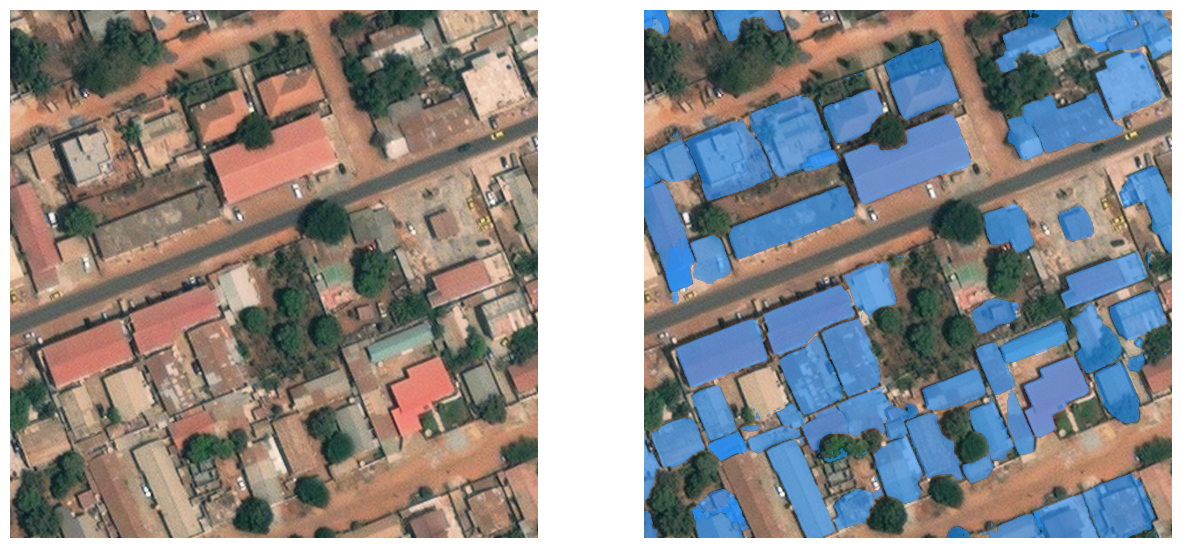

In [36]:
masks, _, _ = predictor.predict_torch(
                point_coords=None,
                point_labels=None,
                boxes=transformed_boxes,
                multimask_output=False,
            )

plot_w_wo_masks(img4Sam, masks, building_boxes_t, point_coords, point_labels, only_pred=False, only_masks=True)